In [ ]:
!pip install tflite-model-maker

In [ ]:
!pip install tensorflow==2.4

      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MIP/models/curr

/content/drive/MyDrive/MIP/models/curr


# Transfer

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam,SGD

In [ ]:
# !tar -xvf 'indian_currency_new.tar'

In [ ]:
[i for i in os.listdir('./indian_currency_new')]

['train', 'test']

In [ ]:
classes = {}
for i in os.listdir('./dataset/'):
    ct = 0
    for j in os.listdir(f'./dataset/{i}'):
        ct += 1
    classes[i] = ct

In [ ]:
datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)

train_generator = datagen.flow_from_directory(
    './dataset/', 
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    classes = list(classes.keys())
)

val_generator = datagen.flow_from_directory(
    './dataset/',
    target_size = (128, 128),
    batch_size =32,
    class_mode = 'categorical',
    subset = 'validation'
    classes = list(classes.keys())
)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation = 'softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
x = model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
24/24 [==============================] - 17s 568ms/step - loss: 2.1962 - accuracy: 0.4090 - val_loss: 6.9128 - val_accuracy: 0.1667
Epoch 2/30
24/24 [==============================] - 12s 504ms/step - loss: 0.5240 - accuracy: 0.8322 - val_loss: 15.6401 - val_accuracy: 0.1333
Epoch 3/30
24/24 [==============================] - 12s 515ms/step - loss: 0.2671 - accuracy: 0.9232 - val_loss: 12.9772 - val_accuracy: 0.1611
Epoch 4/30
24/24 [==============================] - 12s 514ms/step - loss: 0.2587 - accuracy: 0.9213 - val_loss: 13.5300 - val_accuracy: 0.1611
Epoch 5/30
24/24 [==============================] - 12s 521ms/step - loss: 0.1290 - accuracy: 0.9561 - val_loss: 12.1288 - val_accuracy: 0.1556
Epoch 6/30
24/24 [==============================] - 12s 510ms/step - loss: 0.2022 - accuracy: 0.9427 - val_loss: 10.5760 - val_accuracy: 0.1611
Epoch 7/30
24/24 [==============================] - 12s 509ms/step - loss: 0.1161 - accuracy: 0.9487 - val_loss: 9.8892 - val_accuracy: 0

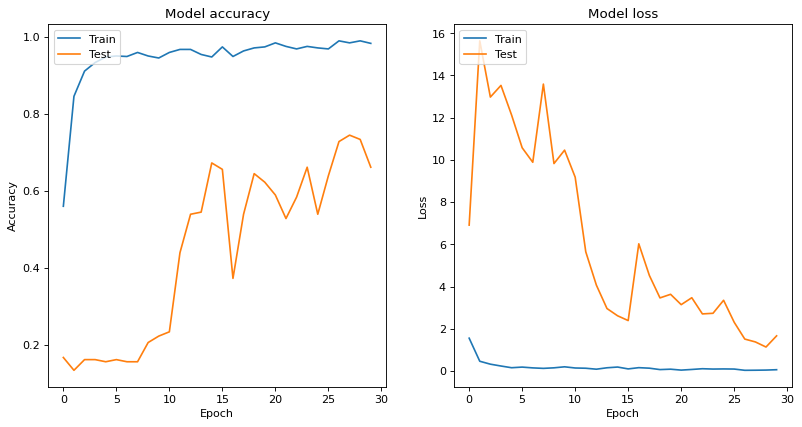

In [ ]:
plt.figure(figsize = (12, 6), dpi = 80)
plt.subplot(1, 2, 1)
plt.plot(x.history['accuracy'])
plt.plot(x.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1, 2, 2)
plt.plot(x.history['loss']) 
plt.plot(x.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.plot()
plt.show()

In [ ]:
model.save("mobilenet_currency.h5")

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('mobilenet_currency.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6tb10mic/assets


#Tflite

In [ ]:
train_data = ImageClassifierDataLoader.from_folder("./dataset/")
train_data, test_data = train_data.split(0.75)

In [ ]:
validation_data, test_data = test_data.split(0.5)

In [ ]:
validation_data

In [ ]:
model = image_classifier.create(train_data, model_spec=model_spec.mobilenet_v2_spec, validation_data=validation_data,epochs=10)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
23/23 [==============================] - 146s 5s/step - loss: 1.8547 - accuracy: 0.3771 - val_loss: 1.1597 - val_accuracy: 0.7031
Epoch 2/10
23/23 [==============================] - 16s 740ms/step - loss: 1.1138 - accuracy: 0.7374 - val_loss: 0.8944 - val_accuracy: 0.7812
Epoch 3/10
23/23 [=======================

In [ ]:
loss, accuracy = model.evaluate(test_data)

3/3 [==============================] - 14s 4s/step - loss: 0.6376 - accuracy: 0.9667


In [ ]:
model.export(export_dir='/content/drive/MyDrive/MIP/models/curr', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in /content/drive/MyDrive/MIP/models/curr/labels.txt.


INFO:tensorflow:Saving labels in /content/drive/MyDrive/MIP/models/curr/labels.txt.


In [ ]:
model.export(export_dir='/content/drive/MyDrive/MIP/models/curr')

INFO:tensorflow:Assets written to: /tmp/tmpgg4xqshz/assets


INFO:tensorflow:Assets written to: /tmp/tmpgg4xqshz/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp1m7xrtny/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmp1m7xrtny/labels.txt.
